In [1]:
# %pip install torchviz

In [2]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os

# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

# Data preprocessing 
- dataloaders
- augmentation pipeline
## Add notes on this here (what is happening)

In [7]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        images = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))
        self.data=[]

        for i in range(len(images)):
            img_path = os.path.join(self.img_dir, images[i])
            mask_path = os.path.join(self.mask_dir, masks[i])

            # get the images
            image = cv2.imread(img_path)
            # cv2 gives BGR switch it to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            #get masks
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            #normalise the images and mask to float32
            image = image/255.0
            mask = mask / 255.0
            #threshold the mask
            
            mask = (mask > 0.5).astype(np.float32)
            mask = torch.tensor(mask)
            inverse_mask = 1- mask
            combined_mask = torch.stack([inverse_mask,mask],dim=0)
            # combined_mask = mask  

            self.data.append((torch.tensor(image, dtype=torch.float32).permute(2,0,1), combined_mask))

            # for any data augmentation we want to do since training with small set and to avoid overfitting
            if self.transform:

                for transformation in self.transform:
                    image = transformation(image)
                    mask = transformation(mask)
                    inverse_mask = 1- mask
                    combined_mask = torch.stack([inverse_mask,mask],dim=0)

                    self.data.append((torch.tensor(image, dtype=torch.float32).permute(2,0,1), combined_mask))
            

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Loading the training dataset

In [8]:
train_dataset = PuzzleDataset(img_dir = "./images-1024x768/train/",
                            mask_dir = "./masks-1024x768/train/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
train_loader = DataLoader(train_dataset,batch_size =1, shuffle=True)

# # # to visualise the images + masks 
# image, mask = train_dataset[2]
# image = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
# print(mask.shape)
# mask = mask.squeeze(0)
# # # Display the images
# plt.figure()
# plt.subplot(1,2,1), plt.imshow(image)
# plt.subplot(1,2,2), plt.imshow(mask)



AttributeError: 'PuzzleDataset' object has no attribute 'images'

# 3.1 Unet Construction
## Add notes on this here (what is happening)

## Vairant 1 : Using `torch.nn.ConvTranspose2d` for upsampling
## Variant 1 : We removed the softmax in the unet with convolve to get to the required number of output classes (ask richard).

In [5]:
# So this is the triple convolution, chat gpt says we should use normalization dont know if we should keep it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)
    
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)

    
# the down module is what the unet uses during the first half 
class Down(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Down, self).__init__()
        self.conv_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            DoubleConv(in_channels,out_channels)
        )

    def forward(self, x):
        ret_ = self.conv_pool(x)
        return ret_

# up transpose, 
class UpConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvTranspose, self).__init__()
        # to determine amount of out channels
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        # adding from the down section
        #x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UpBilinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBilinear, self).__init__()
        # the bilinear is provided by the nn module, we set the mode to bilinear here
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels,mode):
        super(Up, self).__init__()
        if(mode=='convtranspose'):
            self.conv_pool = nn.Sequential(
                UpConvTranspose(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        else:
            self.conv_pool = nn.Sequential(
                UpBilinear(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        
        self.dconv = DoubleConv(out_channels*2,out_channels)
    
    def forward(self,x1,x2):
        x = self.conv_pool(x1)
        return self.dconv(torch.cat([x,x2],dim=1))

    
class SoftMax(nn.Module):
    def __init__(self, in_channels):
        super(SoftMax, self).__init__()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(x)
        return torch.argmax(x,dim=1)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, variant='convtranspose'):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.variant = variant

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)
        
        self.up1 = Up(1024,512,variant)
        self.up2 = Up(512, 256,variant)
        self.up3 = Up(256, 128,variant)
        self.up4 = Up(128, 64,variant)

        self.outc = nn.Conv2d(64,2, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits
    

: 

NOTE: I just pushed to the cpu when I try putting the model on the gpu I get weird errors in training 
that I used up all the GPU memory maybe you wont get this error then just comment out `device="cpu"
`

In [6]:
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device")
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')  # Example: 3 input channels, 2 output classes
model = model.to(device)

# Define the loss function
criterion = nn.BCEWithLogitsLoss() 

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(device)
num_epochs = 10  # Set the number of epochs

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, masks in tqdm(train_loader):
        # Move data to the device (GPU/CPU)
        images, masks = images.to(device), masks.to(device)
        print("identifier",masks.shape)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        outputs = outputs.float()
        print(outputs.shape)
        # print("outputs",outputs.shape)
        # print("masks",masks.shape)
        # Compute the loss
        
        loss = criterion(outputs, masks)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# run tensorboard --logdir=runs to see network

device
cpu


  0%|          | 0/10 [00:00<?, ?it/s]

identifier torch.Size([1, 2, 768, 1024])


In [103]:
def display_tensor_as_image(tensor, channel_num, channel_index, height_index, width_index):
    # Move the tensor to CPU and convert it to a NumPy array
    tensor_np = tensor.cpu().numpy()
    if channel_index == 1:
        tensor_np = tensor_np.squeeze(0)

        channel_index -=1
        height_index-=1
        width_index-=1
        
    # Handle single-channel (grayscale) image
    if channel_num == 1:
        image_np = tensor_np.squeeze(channel_index)  # Remove the channel dimension
        plt.imshow(image_np, cmap="gray")
        plt.title("Single-channel image")
        plt.show()
    
    # Handle two-channel image (display channels separately)
    elif channel_num == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
        for i in range(2):
            channel_image = tensor_np[i]  # Select each channel (e.g., 0 and 1)
            axes[i].imshow(channel_image, cmap="gray")
            axes[i].set_title(f"Channel {i}")
            print(f"Max value in channel {i}:", np.max(channel_image))
            print(f"Min value in channel {i}:", np.min(channel_image))
        plt.show()
    
    # Handle three-channel image (RGB)
    elif channel_num == 3:
        print(tensor_np.shape)
        # Transpose from (channels, height, width) to (height, width, channels)
        image_np = np.transpose(tensor_np, (height_index, width_index, channel_index))
        plt.imshow(image_np)
        plt.title("Three-channel image (RGB)")
        plt.show()


['image-10.png', 'image-12.png', 'image-2.png', 'image-21.png', 'image-24.png', 'image-27.png', 'image-28.png', 'image-30.png', 'image-43.png', 'image-7.png']
['mask-10.png', 'mask-12.png', 'mask-2.png', 'mask-21.png', 'mask-24.png', 'mask-27.png', 'mask-28.png', 'mask-30.png', 'mask-43.png', 'mask-7.png']
torch.Size([1, 3, 768, 1024])
(3, 768, 1024)


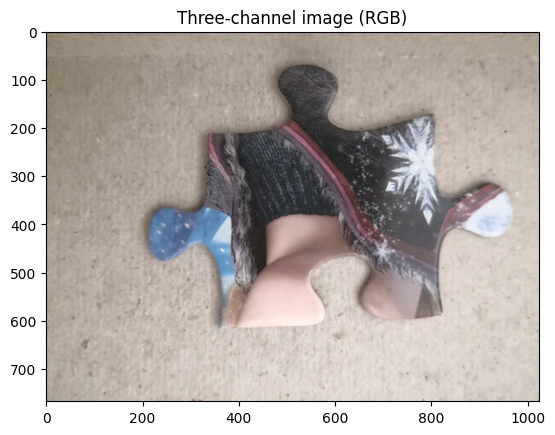

after softmax torch.Size([1, 2, 768, 1024])
Max value in channel 0: 0.95349395
Min value in channel 0: 0.0025369544
Max value in channel 1: 0.997463
Min value in channel 1: 0.04650607


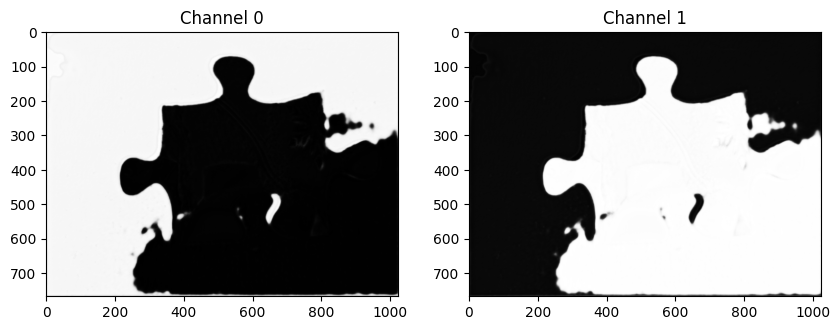

after argmax torch.Size([768, 1024])
Max value in channel 0: 1
Min value in channel 0: 0


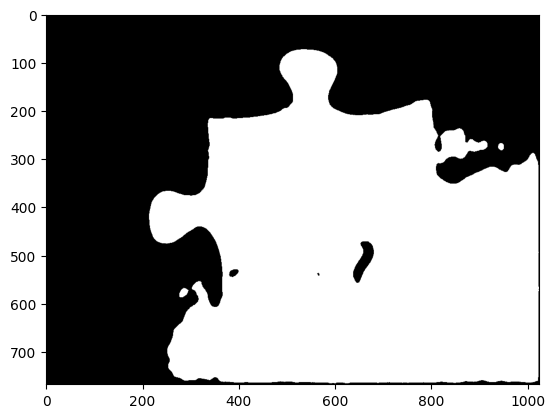

In [104]:
test_dataset = PuzzleDataset(img_dir = "./images-1024x768/train/",
                            mask_dir = "./masks-1024x768/train/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)
model.eval()
for image,mask in test_loader:
    images = image.to(device)
    print(images.shape)
    display_tensor_as_image(images,3,1,2,3)

    with torch.no_grad():
        outputs = model(images)
        #apply the softmax here not in the network
        probs = torch.softmax(outputs, dim = 1 )
        print("after softmax",probs.shape)

        # Swap Channel code
        # temp = probs[0][0].clone()
        # probs[0][0] = probs[0][1]
        # probs[0][1] = temp

        display_tensor_as_image(probs,2,1,2,3)
        probs = probs.squeeze(0)
        predicted_mask = torch.argmax(probs, dim=0)
        print("after argmax",predicted_mask.shape)
        image_np =  predicted_mask.cpu().numpy()
        print(f"Max value in channel {0}:", np.max(image_np))
        print(f"Min value in channel {0}:", np.min(image_np))
        plt.imshow(image_np ,vmin=0, vmax=1,cmap='gray')
        break
    # just for the push
    

## Vairant 2: Using `torch.nn.Upsample` for bilinear upsampling

# 3.2 Training and evaluation 
### Training
- [ ] Implement the training loop with binary cross entropy loss for pixel-wise classification
- [ ] Adam Optimiser to update the model parameters
**Note** have regularly saved checkpoints and evaluate model in the validation set to avoid over fitting

### Weights and biases integration
Log the following:
- [ ] Track BCE loss over epochs
- [ ] IoU for both training and validation sets to monitor the segmentation performance

### Need to submit from the wandb dashboard
- Loss curves (training and validation over epochs)
- IoU curves (training and validation over epochs)

### Remember to comment on comment on whether the model is overfitting and how to recognise this and deal with the problem

### Evaluation
evaluate model on test set 
- accuracy
- precision
- recall
- F1 score
- IoU

# Select the best model based on the validation IoU and report its performance on the test set

# 4 Other architectures
